<a href="https://colab.research.google.com/github/Salvoaf/labDeepLearning/blob/main/13_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence processing with convnets

- Chapter 6, Section 4 of [Deep Learning with Python, v2](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

Human Activity Recognition, or HAR for short, is the problem of predicting what a person is doing based on a trace of their movement using sensors.

A standard human activity recognition dataset is the ‘Activity Recognition Using Smart Phones Dataset’ made available in 2012 https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones.

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"
!unzip 'UCI HAR Dataset.zip'

--2022-11-24 23:42:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  32.3MB/s    in 1.8s    

2022-11-24 23:42:52 (32.3 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  infl

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM
from keras.utils import to_categorical

## Load Data ##
The first step is to load the raw dataset into memory.

There are three main signal types in the raw data: total acceleration, body acceleration, and body gyroscope. Each has three axes of data. This means that there are a total of nine variables for each time step.

Further, each series of data has been partitioned into overlapping windows of 2.65 seconds of data, or 128 time steps.
This means that one row of data has (128 * 9), or 1,152, elements.

The signals are stored in the /Inertial Signals/ directory under the train and test subdirectories. Each axis of each signal is stored in a separate file, meaning that each of the train and test datasets have nine input files to load and one output file to load. We can batch the loading of these files into groups given the consistent directory structures and file naming conventions.

The input data is in CSV format where columns are separated by whitespace. Each of these files can be loaded as a NumPy array. The load_file() function below loads a dataset given the file path to the file and returns the loaded data as a NumPy array.

In [ ]:
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

We can then load all data for a given group (train or test) into a single three-dimensional NumPy array, where the dimensions of the array are **[samples, time steps, features]**.

To make this clearer, there are 128 time steps and nine features, where the number of samples is the number of rows in any given raw signal data file.

The *load_group()* function below implements this behavior. The *dstack()* NumPy function allows us to stack each of the loaded 3D arrays into a single 3D array where the variables are separated on the third dimension (features).

In [ ]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

The *load_dataset_group()* function below loads all input signal data and the output data for a single group using the consistent naming conventions between the train and test directories.

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

Finally, we can load each of the train and test datasets.

The output data is defined as an integer for the class number. We must one hot encode these class integers so that the data is suitable for fitting a neural network multi-class classification model. We can do this by calling the *to_categorical()* Keras function.

The load_dataset() returns the train and test X and y elements ready for fitting and evaluating the defined models.

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

In [ ]:
trainX, trainy, testX, testy = load_dataset()
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


## Implementing a 1D convnet

Neural networks for Computer Vision typically exploit **2D convolutional layers**.

In sequence analysis, instead, the building block is the [**1D convolutional layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D):


*   As in Conv2D, we need to specify the number of filters
*   As in Conv2D, we need to specify the filter size but
  *   in Conv2D we specify two integers (or just one for squared kernels)
  *   in Conv1D we specify a single integer and the kernel is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs

1D convnets are structured in the same way as their 2D counter-parts: they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution 
layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would 
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's define the model as having two 1D CNN layers, followed by a dropout layer for regularization, then a pooling layer. It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/4 their size, consolidating them to only the most essential elements.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We cannot judge the skill of the model from a single evaluation.

The reason for this is that neural networks are stochastic, meaning that a different specific model will result when training the same model configuration on the same data.

We will repeat the evaluation of the model multiple times, then summarize the performance of the model across each of those runs. For example, we can evaluate the model a total of 10 times. This will result in a population of model evaluation scores that must be summarized.

In [ ]:
epochs, batch_size = 10, 32

# repeat experiment
repeats = 3
scores = list()
for r in range(repeats):
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    accuracy = accuracy * 100.0
    print('>#%d: %.3f' % (r+1, accuracy))
    scores.append(accuracy)

# summarize results
print(scores)
m, s = np.mean(scores), np.std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

Epoch 1/10
230/230 [==============================] - 14s 54ms/step - loss: 0.3779 - accuracy: 0.8496
Epoch 2/10
230/230 [==============================] - 7s 31ms/step - loss: 0.1330 - accuracy: 0.9444
Epoch 3/10
230/230 [==============================] - 6s 25ms/step - loss: 0.1186 - accuracy: 0.9491
Epoch 4/10
230/230 [==============================] - 6s 25ms/step - loss: 0.1318 - accuracy: 0.9490
Epoch 5/10
230/230 [==============================] - 6s 25ms/step - loss: 0.1044 - accuracy: 0.9561
Epoch 6/10
230/230 [==============================] - 6s 25ms/step - loss: 0.0979 - accuracy: 0.9573
Epoch 7/10
230/230 [==============================] - 6s 25ms/step - loss: 0.1031 - accuracy: 0.9543
Epoch 8/10
230/230 [==============================] - 7s 30ms/step - loss: 0.1017 - accuracy: 0.9539
Epoch 9/10
230/230 [==============================] - 8s 36ms/step - loss: 0.0862 - accuracy: 0.9610
Epoch 10/10
230/230 [==============================] - 6s 25ms/step - loss: 0.0904 - accur

##Tuning the 1D convnet##

Data Preparation

In the previous section, we did not perform any data preparation. We used the data as-is.

One possible transformation that may result in an improvement is to standardize the observations prior to fitting a model.

Standardization refers to shifting the distribution of each variable such that it has a mean of zero and a standard deviation of 1. It realy only makes sense if the distribution of each variable is Gaussian.

We can quickly check the distribution of each variable by plotting a histogram of each variable in the training dataset.

A minor difficulty in this is that the data has been split into windows of 128 time steps, with a 50% overlap. Therefore, in order to get a fair idea of the data distribution, we must first remove the duplicated observations (the overlap), then remove the windowing of the data.

We can do this using NumPy, first slicing the array and only keeping the second half of each window, then flattening the windows into a long vector for each variable. This is quick but we lose the data in the first half of the first window.

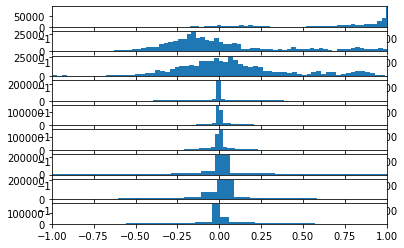

In [ ]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	plt.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		plt.hist(longX[:, i], bins=100)
	plt.show()

# plot histograms
plot_variable_distributions(trainX)

The data is sufficiently Gaussian-like to explore whether a standardization transform will help the model extract salient signal from the raw observations.

The function below named *scale_data()* can be used to standardize the data prior to fitting and evaluating the model. The StandardScaler scikit-learn class will be used to perform the transform. It is first fit on the training data (e.g. to find the mean and standard deviation for each variable), then applied to the train and test sets.

The standardization is optional, so we can apply the process and compare the results to the same code path without the standardization in a controlled experiment.

In [ ]:
# standardize data
def scale_data(trainX, testX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    # flatten train and test
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    # standardize
    s = StandardScaler()
    # fit on training data
    s.fit(longX)
    # apply to training and test data
    longX = s.transform(longX)
    flatTrainX = s.transform(flatTrainX)
    flatTestX = s.transform(flatTestX)
    # reshape
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX

We can now compare the results of a model fit as before and a model fit on the dataset after it has been standardized.

Epoch 1/10
230/230 [==============================] - 6s 26ms/step - loss: 0.0378 - accuracy: 0.9846
Epoch 2/10
230/230 [==============================] - 6s 28ms/step - loss: 0.0321 - accuracy: 0.9868
Epoch 3/10
230/230 [==============================] - 6s 25ms/step - loss: 0.0310 - accuracy: 0.9874
Epoch 4/10
230/230 [==============================] - 6s 28ms/step - loss: 0.0393 - accuracy: 0.9835
Epoch 5/10
230/230 [==============================] - 6s 25ms/step - loss: 0.0294 - accuracy: 0.9888
Epoch 6/10
230/230 [==============================] - 6s 26ms/step - loss: 0.0345 - accuracy: 0.9857
Epoch 7/10
230/230 [==============================] - 6s 25ms/step - loss: 0.0344 - accuracy: 0.9861
Epoch 8/10
230/230 [==============================] - 6s 26ms/step - loss: 0.0318 - accuracy: 0.9867
Epoch 9/10
230/230 [==============================] - 6s 25ms/step - loss: 0.0296 - accuracy: 0.9867
Epoch 10/10
230/230 [==============================] - 6s 26ms/step - loss: 0.0296 - accura

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6129dd43d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f61289d7350>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f61289d12d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f61289d7e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f61289dd390>,
 'means': []}

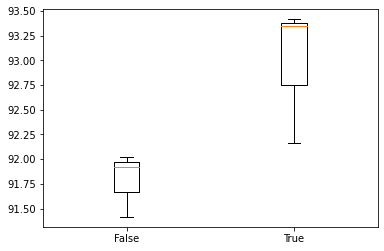

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# repeat experiment
all_scores = list()

scores = list()
for r in range(3):
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    accuracy = accuracy * 100.0
    print('>#%d: %.3f' % (r+1, accuracy))
    scores.append(accuracy)
all_scores.append(scores)


scores = list()
for r in range(repeats):
    # scale data
    X_tr, X_te = scale_data(trainX, testX)
    # fit network
    model.fit(X_tr, trainy, epochs=epochs, batch_size=batch_size)
    # evaluate model
    _, accuracy = model.evaluate(X_te, testy, batch_size=batch_size, verbose=0)
    accuracy = accuracy * 100.0
    print('>#%d: %.3f' % (r+1, accuracy))
    scores.append(accuracy)
all_scores.append(scores)

params = [False, True]
# summarize mean and standard deviation
for i in range(len(all_scores)):
    m, s = np.mean(all_scores[i]), np.std(all_scores[i])
    print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
# boxplot of scores
plt.boxplot(all_scores, labels=[False, True])

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 45.5 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
def build_model(hp):
    hp_filters = hp.Int('filters', min_value = 5, max_value = 100, step = 5)     # <--------- first HP
    hp_units = hp.Int('dense_units', min_value = 10, max_value = 100, step = 10) # <--------- second HP
    hp_drop_rate = hp.Float('dropout_rate', min_value = 0, max_value = 0.8)      # <--------- third HP

    model = Sequential()
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu'))
    model.add(Dropout(hp_drop_rate))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hp_units, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 27, # from the docs: It is recommended to set this to a value slightly higher than the expected time to convergence for your largest Model, and to use early stopping during training
                     directory = '13_HyperParams',
                     project_name = '13_KerasTuner')    

Print a summary of the search space.

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 100, 'step': 5, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': None}


In [ ]:
X_tr, X_te = scale_data(trainX, testX)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  patience=5, restore_best_weights=True)]
tuner.search(X_tr, trainy, epochs=50, validation_split=0.2, callbacks=callbacks)

Trial 70 Complete [00h 01m 14s]
val_accuracy: 0.9401767253875732

Best val_accuracy So Far: 0.9483344554901123
Total elapsed time: 00h 29m 35s


Print a summary of the results.

In [ ]:
tuner.results_summary()

Results summary
Results in 13_HyperParams/13_KerasTuner
Showing 10 best trials
Trial summary
Hyperparameters:
filters: 50
dense_units: 70
dropout_rate: 0.5663344192492131
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9483344554901123
Trial summary
Hyperparameters:
filters: 75
dense_units: 90
dropout_rate: 0.5801594429985241
tuner/epochs: 9
tuner/initial_epoch: 3
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0032
Score: 0.9456152319908142
Trial summary
Hyperparameters:
filters: 95
dense_units: 70
dropout_rate: 0.7108742397330973
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9408565759658813
Trial summary
Hyperparameters:
filters: 80
dense_units: 60
dropout_rate: 0.261213855272395
tuner/epochs: 27
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9401767253875732
Trial summary
Hyperparameters:
filters: 15
dense_units: 50
dropout_rate: 0.24149447441549976
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracke

Get the optimal hyperparameters and the best model

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]

print(f"Number of conv filters: {best_hps.get('filters')} \nNumber of hidden units: {best_hps.get('dense_units')} \nDropout rate: {best_hps.get('dropout_rate')}")

Number of conv filters: 50 
Number of hidden units: 70 
Dropout rate: 0.5663344192492131


In [ ]:
best_model = tuner.get_best_models(num_models = 1)[0]

Build a new model from scratch with the best hyperparameter configuration.

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
best_model.evaluate(X_te, testy)

93/93 [==============================] - 1s 8ms/step - loss: 0.3009 - accuracy: 0.9013


[0.3008520305156708, 0.9012554883956909]

##Multi-Headed Convolutional Neural Network##

Another popular approach with CNNs is to have a multi-headed model, where each head of the model reads the input time steps using a different sized kernel.

For example, a three-headed model may have three different kernel sizes of 3, 5, 11, allowing the model to read and interpret the sequence data at three different resolutions. The interpretations from all three heads are then concatenated within the model and interpreted by a fully-connected layer before a prediction is made.

We can implement a multi-headed 1D CNN using the Keras functional API.

We can see that each head of the model is the same structure, although the kernel size is varied. The three heads then feed into a single merge layer before being interpreted prior to making a prediction.
Other aspects of the model could be varied across the heads, such as the number of filters.

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


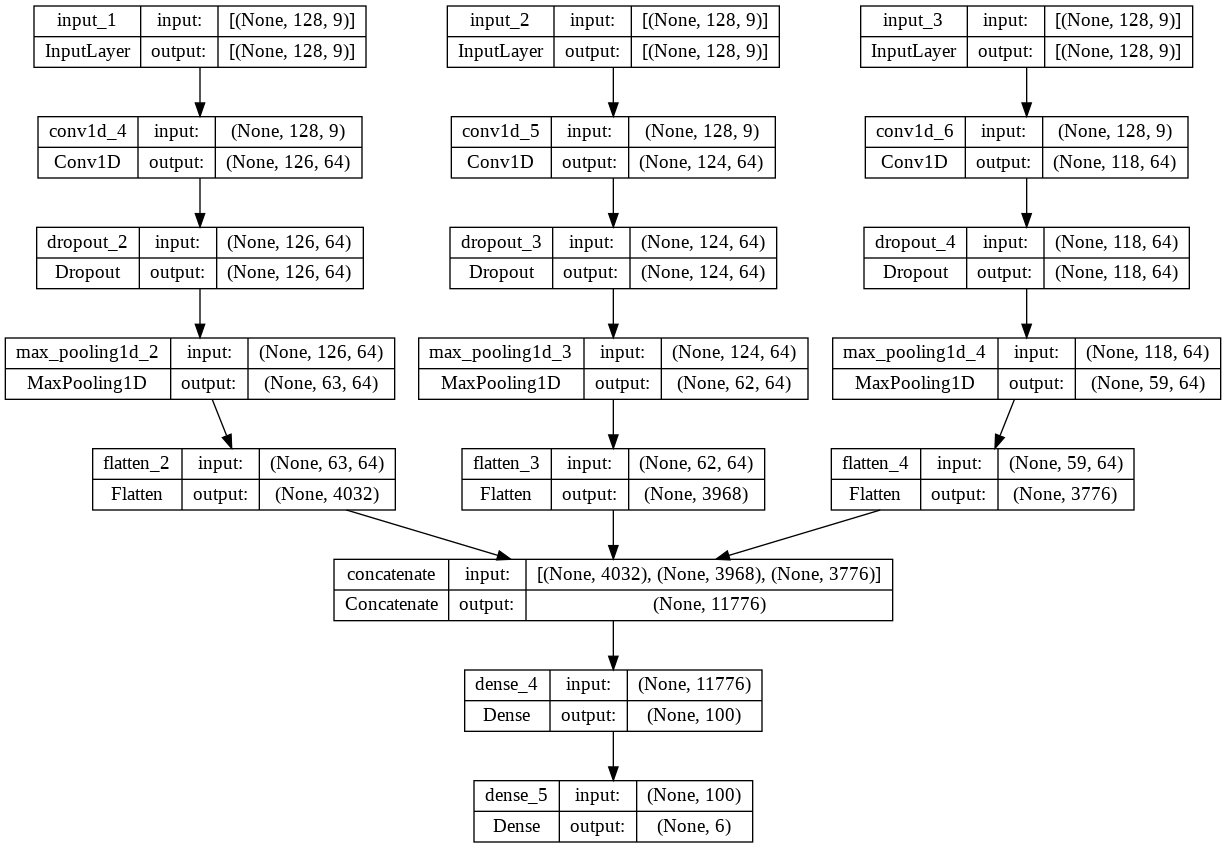

In [ ]:
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

# head 1
inputs1 = Input(shape=(n_timesteps,n_features))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# head 2
inputs2 = Input(shape=(n_timesteps,n_features))
conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# head 3
inputs3 = Input(shape=(n_timesteps,n_features))
conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = tf.keras.layers.concatenate([flat1, flat2, flat3], axis=-1)
# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(n_outputs, activation='softmax')(dense1)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

SVG(model_to_dot(model, show_shapes=False, show_layer_names=True, dpi=100).create(prog='dot', format='svg'))

# save a plot of the model
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/[AIDE] 2022-2023 - Data/13_multi-headed_CNN.png')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# repeat experiment
repeats = 3
scores = list()
for r in range(repeats):
    # fit network
    model.fit([trainX, trainX, trainX], trainy, epochs=epochs, batch_size=batch_size)
    # evaluate model
    _, accuracy = model.evaluate([testX, testX, testX], testy, batch_size=batch_size, verbose=0)
    accuracy = accuracy * 100.0
    print('>#%d: %.3f' % (r+1, accuracy))
    scores.append(accuracy)

# summarize results
print(scores)
m, s = np.mean(scores), np.std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

Epoch 1/10
230/230 [==============================] - 12s 46ms/step - loss: 0.3279 - accuracy: 0.8708
Epoch 2/10
230/230 [==============================] - 15s 64ms/step - loss: 0.1218 - accuracy: 0.9498
Epoch 3/10
230/230 [==============================] - 10s 43ms/step - loss: 0.1060 - accuracy: 0.9542
Epoch 4/10
230/230 [==============================] - 10s 42ms/step - loss: 0.0974 - accuracy: 0.9595
Epoch 5/10
230/230 [==============================] - 10s 42ms/step - loss: 0.0969 - accuracy: 0.9588
Epoch 6/10
230/230 [==============================] - 10s 42ms/step - loss: 0.0971 - accuracy: 0.9569
Epoch 7/10
230/230 [==============================] - 10s 41ms/step - loss: 0.0833 - accuracy: 0.9614
Epoch 8/10
230/230 [==============================] - 10s 42ms/step - loss: 0.0790 - accuracy: 0.9641
Epoch 9/10
230/230 [==============================] - 12s 51ms/step - loss: 0.1117 - accuracy: 0.9574
Epoch 10/10
230/230 [==============================] - 10s 41ms/step - loss: 0.087

## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing 
temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` 
layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.

One useful and important concept that we will not cover in these pages is that of 1D convolution with dilated kernels.